In [43]:
%matplotlib inline

# Selecting meaningful features

学習機械がトレーニングデータにOverfitしてしまった("Varianceが大きい")！→対処法は4つ
- Collect more training data
- Introduce a penalty for complexity via regularization
- Choose a simpler model with fewer parameters
- Reduce the dimensionality of the data

今回の話は2つ扱う
- regularization (正則化)
- dimensionality reduction via feature selection (特徴選択による，データの次元削減)

章のまとめ:
categorical variables correctly, and we have seen how we can map ordinal and nominal features values to integer representations.

ここから:
L1 正則化． 過学習を防ぐ．
関係ない変数を削除するために Sequential Backward Selection (SBS)
(Interpretability が高い) Random Forestによる特徴選択

今回の章では，変数をまるごと削除する以外の方法は扱わなかった
次章では，低次元の特徴を抽出する=特徴量を圧縮する．「特徴抽出」

## 1. L1正則化
でスパースな解が見つかる

これまでは L2ノルムを使ったが，ここではL1ノルムをつかってみる

L2よりもL1を使ったほうが，解がスパースになる
→データの次元のうち，多くの次元が意味をなさないとき，これはありがたい

### L1正則化の効用
は，コスト関数(minimizeしたいもの)を図示すると分かる

#### 図示してみましょう
コスト関数 = 二乗誤差の総和 (SSE; Sum of Squared Errors) の場合

L1正則化をすると，使うパラメーターの個数が減る(上や右の軸上に接点)．これによって自由度が下がり，過学習が防がれる
L2正則化をすると，パラメーターのバランスが良くなる(右上に接点= w_1 と w_2 が同程度になる)．これによって自由度が下がり，過学習が防がれる

### L1正則化の効果を実際に見てみましょう
Logistic regressionで

In [44]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=0.1)
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))


Training accuracy: 0.983870967742
Test accuracy: 0.981481481481


In [45]:
# データのインポート
import pandas as pd
import numpy as np
df_wine = pd.read_csv('./data/ch4_wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol',
'Malic acid', 'Ash',
'Alcalinity of ash', 'Magnesium',
'Total phenols', 'Flavanoids',
'Nonflavanoid phenols',
'Proanthocyanins',
'Color intensity', 'Hue',
'OD280/OD315 of diluted wines',
'Proline']

# クラス3種類
print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

# CV用の分割とスケーリング
from sklearn.cross_validation import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

# 回帰実行
lr.fit(X_train_std, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Class labels [1 2 3]


In [46]:
lr.intercept_

array([-0.38374638, -0.15813946, -0.70041213])

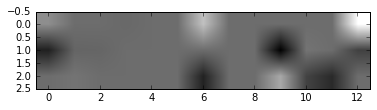

array([[ 0.2798601 ,  0.        ,  0.        , -0.02793377,  0.        ,
         0.        ,  0.71005052,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.23660469],
       [-0.6437431 , -0.06888552, -0.05718829,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.92715223,
         0.05989205,  0.        , -0.37101355],
       [ 0.        ,  0.06152268,  0.        ,  0.        ,  0.        ,
         0.        , -0.63609866,  0.        ,  0.        ,  0.49814659,
        -0.35816981, -0.57117721,  0.        ]])

In [47]:
from IPython.core.display import display
display(lr.coef_)
plt.imshow(lr.coef_)
plt.gray()
plt.show()

確かに係数がスパースになった

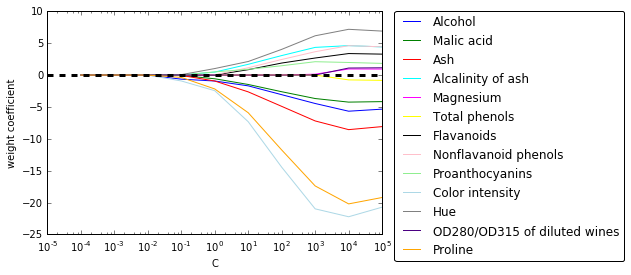

In [48]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)
    
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4, 6):
    lr = LogisticRegression(penalty='l1', C=10**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
# plt.savefig('./figures/l1_path.png', dpi=300)
plt.show()

# 2. Sequential feature selection algorithms
データの次元削減をしよう

(特徴選択) Feature selection → 全変数のなかから一部に絞る
(特徴抽出) Feature extraction → 元の変数から低次元の特徴量を作る

今回は特徴選択．(5章で特徴抽出)

問題設定
d次元の変数からk次元を自動で選ぶ

モチベーション
汎化誤差が下がる(余計な情報を使わないことになるので)
以下の方法は，正則化ができないアルゴリズムで便利(正則化できるならL1ノルムが特徴選択になる)

Sequential Backward Selection (SBS)
強い
- reduce the dimensionality of the initial feature subspace
- with a minimum decay in performance of the classifier to improve upon computational efficiency.
- In certain cases, SBS can even improve the predictive power of the model if a model suffers from overfitting.

仕組み
- 初期状態: 全変数
- 各ステップ: 1つずつ変数を減らしていく(Greedy)
- 減らし方: 基準になる関数 J(j) (jは削除した変数のインデックス)を最小化するように減らす(例. 変数x_jを削除した場合のパフォーマンスの悪化の程度 J(j))

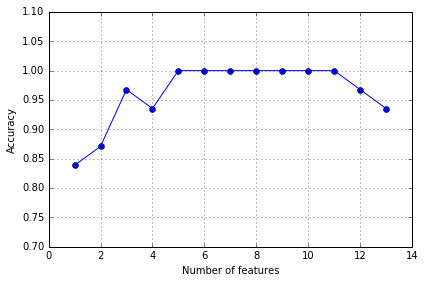

In [49]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score


import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

最少5個の変数で100%の正答率(サンプルでの誤差)が達成されている
12個目からはむしろ低下する(過学習)

問題の5つの変数はというと．．．

In [50]:
k5 = list(sbs.subsets_[8])
print(df_wine.columns[1:][k5])

Index(['Alcohol', 'Malic acid', 'Alcalinity of ash', 'Hue', 'Proline'], dtype='object')


これらが，選択された特徴量 -- 大雑把に言うと，ワインを分類するときはこの5つでだいたい分けられる
- アルコール度数
- リンゴ酸
- 灰にした時のアルカリ度
- 色合い
- プロリン(アミノ酸)

さて，汎化誤差はどうなるか

In [51]:
# 全変数
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.983870967742
Test accuracy: 0.944444444444


In [52]:
# 選択した5個の変数
knn.fit(X_train_std[:, k5], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k5], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k5], y_test))

Training accuracy: 0.959677419355
Test accuracy: 0.962962962963


There are many more feature selection algorithms available via scikit-learn.
- recursive backward elimination based on feature weights
- tree-based methods to select features by importance
- univariate statistical tests

More info at http://scikit-learn.org/stable/modules/feature_selection.html

# Random forest で特徴量の重要性を分析
"データが線型分離可能でなくても使える" ← @todo これまではその仮定をしていたか？？

Scikit-learn では Random forest で分析すると自動的に重要性も測っておいてくれる
i.e. 変数のIG(Information gain)を計算しておいてくれる

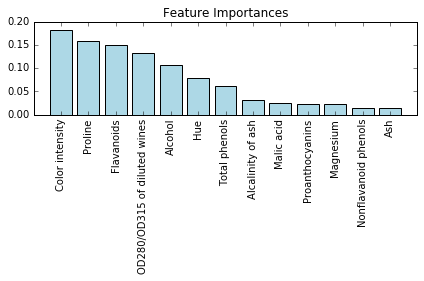

 1) Color intensity                0.182483
 2) Proline                        0.158610
 3) Flavanoids                     0.150948
 4) OD280/OD315 of diluted wines   0.131987
 5) Alcohol                        0.106589
 6) Hue                            0.078243
 7) Total phenols                  0.060718
 8) Alcalinity of ash              0.032033
 9) Malic acid                     0.025400
10) Proanthocyanins                0.022351
11) Magnesium                      0.022078
12) Nonflavanoid phenols           0.014645
13) Ash                            0.013916


In [55]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=10000,
                                random_state=0,
                                n_jobs=-1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('./random_forest.png', dpi=300)
plt.show()

ここでimportanceは，全体で足して1になるように正規化されている．

Random forestを特徴選択に使うときは，
forest.transform() を使うと便利．
重要性の閾値を設定して，全体の15%以上の重要性を持っている変数のみを後の処理において使う，などの操作ができる．

In [57]:
X_selected = forest.transform(X_train, threshold=0.15)
X_selected.shape

(124, 3)

/Users/TakeshiTeshima/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


と思いきや，deprecatedらしい．
SelectFromModel を代わりに使えとのこと．

In [63]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(forest, threshold=0.15, prefit=True)
X_selected = sfm.transform(X_train)
# 選択された変数(データ)のshapeを表示
print(X_selected.shape)

# 選択されたfeatureを表示しておく
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

(124, 3)
 1) Color intensity                0.182483
 2) Proline                        0.158610
 3) Flavanoids                     0.150948
